In [76]:
import joblib
import warnings

import pandas as pd

from utils.plot import *
from utils.scaler import *
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

In [32]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [33]:
df = pd.read_csv('Database/rainfall_train.csv', index_col=0)
df_test = pd.read_csv('Database/rainfall_test.csv')
train_col = df.columns.tolist()
train_col.remove(train_col[-2])
df_test.columns = train_col
train, self_test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

# Train General Preprocessing

In [34]:
df_1 = train.copy()
mask = df_1['rainfall_train.class_interval'] == -999
df_1 = df_1[~mask]

delete_list = ['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour',
               'rainfall_train.ef_year', 'rainfall_train.vv']
df_1 = df_1.drop(columns=delete_list)

# Train 이산형변수 처리

In [35]:
df_2 = df_1.copy()

original_values = list(range(3, 241, 3))
reversed_values = original_values[::-1]
mapping_table = dict(zip(original_values, reversed_values))


def map_value(x):
    if pd.isna(x):
        return x
    return mapping_table.get(x, x)


df_2['rainfall_train.dh'] = df_2['rainfall_train.dh'].apply(map_value)

In [36]:
enc_dict = {}
onehot_df = pd.DataFrame(index=df_2.index)
for i, col in enumerate(['rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']):
    enc_dict[i] = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    one_hot_encoded = enc_dict[i].fit_transform(pd.DataFrame(df_2[col]))

    encoded_df = pd.DataFrame(one_hot_encoded, columns=enc_dict[i].get_feature_names_out([col]), index=df_2.index)
    onehot_df = pd.concat([onehot_df, encoded_df], axis=1)
    df_2 = df_2.drop(columns=[col])
df_2 = pd.concat([df_2, onehot_df], axis=1)

# Train 파생변수

In [37]:
df_3 = df_2.copy()

continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09']

df_3.insert(11, 'cum_prob', df_3[continuous_list].sum(axis=1))
df_3.insert(12, 'Zero_Count', (df_3[continuous_list] == 0).sum(axis=1))

# Train 정규화

In [38]:
df_4 = df_3.copy()

minmax_list = ['rainfall_train.dh', 'Zero_Count']
minmax_scaler = MinMaxScaler()
df_4[minmax_list] = minmax_scaler.fit_transform(df_4[minmax_list])

# Train 연속형변수 분포저장

In [39]:
y = df_4['rainfall_train.class_interval']
X = df_4.drop(columns='rainfall_train.class_interval')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)

In [40]:
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()

continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09', 'cum_prob']

X_train_norm.loc[:, continuous_list], scaler = standard_scale_train(X_train, continuous_list)
X_val_norm.loc[:, continuous_list] = standard_scale_val(X_val, continuous_list, scaler)

# 불균형 해소를 위한 학습파일 저장

In [41]:
total_train = pd.concat([X_train_norm, y_train], axis=1)
total_val = pd.concat([X_val_norm, y_val], axis=1)

total_train = total_train.iloc[:, 1:]
total_val = total_val.iloc[:, 1:]

train_mask = total_train['rainfall_train.class_interval'] == 0
val_mask = total_val['rainfall_train.class_interval'] == 0

total_train = total_train[~train_mask]
total_val = total_val[~val_mask]

In [42]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_encoded = enc.fit_transform(pd.DataFrame(total_train['rainfall_train.class_interval']))
encoded_df = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(['rainfall_train.class_interval']),
                          index=total_train.index)
total_train = total_train.drop(columns=['rainfall_train.class_interval'])
total_train = pd.concat([total_train, encoded_df], axis=1)

In [43]:
one_hot_encoded = enc.transform(pd.DataFrame(total_val['rainfall_train.class_interval']))
encoded_df = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(['rainfall_train.class_interval']),
                          index=total_val.index)
total_val = total_val.drop(columns=['rainfall_train.class_interval'])
total_val = pd.concat([total_val, encoded_df], axis=1)

In [44]:
# total_train.to_csv('Database/total/total_train.csv')
# total_val.to_csv('Database/total/total_val.csv')

# test General Preprocessing

In [45]:
self_test = True

if self_test:
    df_1 = self_test_df.copy()
if not self_test:
    df_1 = df_test.copy()

mask = df_1['rainfall_train.class_interval'] == -999
df_1 = df_1[~mask]

delete_list = ['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour',
               'rainfall_train.ef_year', 'rainfall_train.vv']
df_1 = df_1.drop(columns=delete_list)

# test 이산형변수 처리

In [46]:
df_2 = df_1.copy()

original_values = list(range(3, 241, 3))
reversed_values = original_values[::-1]
mapping_table = dict(zip(original_values, reversed_values))


def map_value(x):
    if pd.isna(x):
        return x
    return mapping_table.get(x, x)


df_2['rainfall_train.dh'] = df_2['rainfall_train.dh'].apply(map_value)

In [47]:
onehot_df = pd.DataFrame(index=df_2.index)
for i, col in enumerate(['rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']):
    one_hot_encoded = enc_dict[i].transform(pd.DataFrame(df_2[col]))

    encoded_df = pd.DataFrame(one_hot_encoded, columns=enc_dict[i].get_feature_names_out([col]), index=df_2.index)
    onehot_df = pd.concat([onehot_df, encoded_df], axis=1)
    df_2 = df_2.drop(columns=[col])
df_2 = pd.concat([df_2, onehot_df], axis=1)

# test 파생변수

In [48]:
df_3 = df_2.copy()

continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09']

df_3.insert(11, 'cum_prob', df_3[continuous_list].sum(axis=1))
df_3.insert(12, 'Zero_Count', (df_3[continuous_list] == 0).sum(axis=1))

# test 정규화

In [49]:
df_4 = df_3.copy()

minmax_list = ['rainfall_train.dh', 'Zero_Count']
df_4[minmax_list] = minmax_scaler.transform(df_4[minmax_list])

# test 이산형변수 칼럼통일

In [50]:
if self_test:
    y2 = df_4['rainfall_train.class_interval']
    X2 = df_4.drop(columns='rainfall_train.class_interval')

    # train에만 있고 test에 없는 경우, 해당 column name으로 test에 zero columns 추가.
    X2[list(X_val_norm.columns[X_val_norm.columns.isin(X2) == False])] = 0

    # test에만 있고 train에는 없는 경우, 해당 column name은 제거.
    X2 = X2.drop(columns=list(X2.columns[X2.columns.isin(X_val_norm) == False]))
    X2 = X2[X_val_norm.columns]

if not self_test:
    X2 = df_4

    # train에만 있고 test에 없는 경우, 해당 column name으로 test에 zero columns 추가.
    X2[list(X_val_norm.columns[X_val_norm.columns.isin(X2) == False])] = 0

    # test에만 있고 train에는 없는 경우, 해당 column name은 제거.
    X2 = X2.drop(columns=list(X2.columns[X2.columns.isin(X_val_norm) == False]))
    X2 = X2[X_val_norm.columns]

# test 연속형변수 분포통일

In [51]:
continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09', 'cum_prob']

X2.loc[:, continuous_list] = standard_scale_val(X2, continuous_list, scaler)

# 뷸균형 해소

In [53]:
X_train_norm = X_train_norm.iloc[:, 1:]
X_val_norm = X_val_norm.iloc[:, 1:]
X2 = X2.iloc[:, 1:]

In [70]:
import torch
from Module.model import VAE

model = VAE(32, 10000)
model.load_state_dict(torch.load('Weight/VAE.pth'))

<All keys matched successfully>

In [71]:
syn_data = model()

In [72]:
syn_df = pd.DataFrame(syn_data.cpu().detach().numpy(),
                      columns=list(X_train_norm.columns) + ['rainfall_train.class_interval'])

syn_df['rainfall_train.class_interval'] = syn_df['rainfall_train.class_interval'] + 1

In [73]:
syn_df[minmax_list] = syn_df[minmax_list].applymap(lambda x: 1 if x > 1 else x)
syn_df[minmax_list] = syn_df[minmax_list].applymap(lambda x: 0 if x < 0 else x)

In [74]:
X_train_norm[~train_mask]

,rainfall_train.dh,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,...,rainfall_train.ef_day_30,rainfall_train.ef_day_31,rainfall_train.ef_hour_0,rainfall_train.ef_hour_3,rainfall_train.ef_hour_6,rainfall_train.ef_hour_9,rainfall_train.ef_hour_12,rainfall_train.ef_hour_15,rainfall_train.ef_hour_18,rainfall_train.ef_hour_21
1452751,0.696203,2.348428,2.579809,3.099341,3.586163,4.173833,4.938387,6.161024,5.934830,3.484600,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
926455,0.873418,0.672826,0.764343,0.498615,0.174043,-0.024139,-0.446242,-0.325896,-0.191676,-0.125634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
829430,0.784810,1.869685,2.061104,2.535851,2.669474,2.858051,3.015306,2.746856,1.121147,1.679483,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88365,0.341772,2.177448,2.246356,2.362469,2.618547,2.544769,2.342227,3.088273,2.871577,-0.125634,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
890088,0.481013,0.501847,0.579091,0.541961,0.428679,-0.086795,-0.061626,-0.325896,-0.191676,-0.125634,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16012,0.835443,2.280036,2.616859,3.229378,3.891726,4.111177,3.399922,0.869063,-0.191676,-0.125634,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1056215,0.455696,2.109056,2.024054,0.802033,0.123116,0.289143,-0.350088,-0.325896,-0.191676,-0.125634,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
468297,0.924051,2.245840,2.283406,2.319124,2.516693,1.041018,0.419145,-0.325896,-0.191676,-0.125634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1154183,0.063291,0.672826,0.801393,0.932070,1.039805,1.041018,0.515299,0.698355,1.558754,1.679483,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [75]:
syn_df

,rainfall_train.dh,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,...,rainfall_train.ef_day_31,rainfall_train.ef_hour_0,rainfall_train.ef_hour_3,rainfall_train.ef_hour_6,rainfall_train.ef_hour_9,rainfall_train.ef_hour_12,rainfall_train.ef_hour_15,rainfall_train.ef_hour_18,rainfall_train.ef_hour_21,rainfall_train.class_interval
0,0.584523,1.848066,1.975756,2.108251,2.053391,1.765506,0.930666,0.246239,-0.080232,-0.070606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,0.490617,1.601611,1.672260,1.733341,1.695907,1.525265,0.842330,0.314746,0.011737,-0.107159,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
2,0.429311,-0.198202,-0.245803,-0.259742,-0.275022,-0.282535,-0.243574,-0.210311,-0.168884,-0.143662,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.718172,2.204432,2.516517,3.092222,3.593992,4.146667,4.596659,3.658236,1.271847,0.174712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
4,0.410688,0.231334,0.167777,0.105083,0.039467,-0.026883,-0.111646,-0.149528,-0.147835,-0.097340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.393160,1.267147,1.290603,1.309986,1.256428,1.155110,0.907027,0.571839,0.126254,-0.042289,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
9996,0.893894,2.272035,2.599414,3.186919,3.380242,2.661138,0.343846,-0.274813,-0.139510,-0.089814,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
9997,0.346457,1.208498,1.249632,1.311123,1.330910,1.322778,1.241388,1.088935,0.556239,0.142119,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
9998,0.620398,1.801888,1.923989,1.974235,1.711315,1.207762,0.455222,0.053940,-0.069678,-0.086506,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0


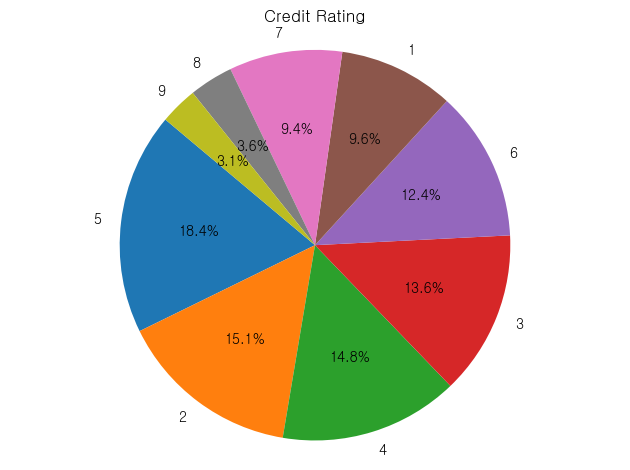

In [78]:
plot_imabalance(pd.DataFrame(y_train)[~train_mask],'rainfall_train.class_interval')

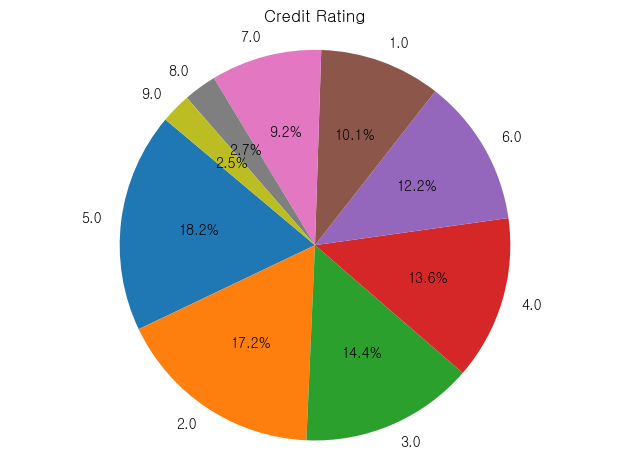

In [79]:
plot_imabalance(syn_df,'rainfall_train.class_interval')

In [39]:
# pd.concat([X_train_norm, syn_df.drop(columns=['rainfall_train.class_interval'])], axis=0)
pd.concat([y_train, syn_df['rainfall_train.class_interval']], axis=0)

877611     0.0
633836     0.0
606061     0.0
1214355    0.0
682391     0.0
          ... 
9995       4.0
9996       2.0
9997       5.0
9998       6.0
9999       3.0
Name: rainfall_train.class_interval, Length: 1248671, dtype: float64

# 지역별 분리

In [94]:
# X_train_norm_dict = {}
# y_train_norm_dict = {}
# 
# for i, STN in enumerate(df['rainfall_train.stn4contest'].unique().tolist()):
#     train_mask = (X_train_norm['rainfall_train.stn4contest'] == STN)
#     X_train_norm_dict[STN] = X_train_norm[train_mask]
#     y_train_norm_dict[STN] = pd.DataFrame(y_train_norm)[train_mask]
# 
# for i, (key, value) in enumerate(X_train_norm_dict.items()):
#     X_train_norm_dict[key] = value.iloc[:, 1:]
# 
# X_val_norm = X_val_norm.iloc[:, 1:]
# X2 = X2.iloc[:, 1:]

# GMM분리

In [21]:
GMM = joblib.load('Database/gmm_model.pkl')
X_train_norm = pd.concat([X_train_norm, pd.DataFrame(GMM.predict(X_train_norm), index=X_train_norm.index)], axis=1)

X_train_norm_dict = {}
y_train_norm_dict = {}

for i, cluster_num in enumerate(X_train_norm[0].unique().tolist()):
    train_mask = (X_train_norm[0] == cluster_num)
    X_train_norm_dict[cluster_num] = X_train_norm[train_mask]
    y_train_norm_dict[cluster_num] = pd.DataFrame(y_train)[train_mask]
    X_train_norm_dict[cluster_num] = X_train_norm_dict[cluster_num].drop(columns=0)

In [22]:
for i, (key, value) in enumerate(X_train_norm_dict.items()):
    print(f'{key} Train set')
    print(value.shape)
    print(y_train_norm_dict[key].shape)

print('Validation set')
print(X_val_norm.shape)
print(y_val.shape)

print('Test set')
print(X2.shape)

if self_test:
    print(y2.shape)

10 Train set
(123072, 57)
(123072, 1)
4 Train set
(97820, 57)
(97820, 1)
1 Train set
(90284, 57)
(90284, 1)
6 Train set
(125411, 57)
(125411, 1)
8 Train set
(150807, 57)
(150807, 1)
9 Train set
(115253, 57)
(115253, 1)
5 Train set
(20187, 57)
(20187, 1)
3 Train set
(54302, 57)
(54302, 1)
7 Train set
(18608, 57)
(18608, 1)
14 Train set
(74820, 57)
(74820, 1)
12 Train set
(93290, 57)
(93290, 1)
0 Train set
(175835, 57)
(175835, 1)
13 Train set
(80389, 57)
(80389, 1)
2 Train set
(5023, 57)
(5023, 1)
11 Train set
(13570, 57)
(13570, 1)
Validation set
(65194, 57)
(65194,)
Test set
(144897, 57)
(144897,)


# 전처리 파일저장

In [23]:
for i, (key, value) in enumerate(X_train_norm_dict.items()):
    value.to_csv(f'Database/train/GMM{key}_X_train_norm.csv')
    y_train_norm_dict[key].to_csv(f'Database/train/GMM{key}_y_train.csv')
    print(f'GMM{key} Train set saved!')

X_val_norm.to_csv(f'Database/val/X_val_norm.csv')
y_val.to_csv(f'Database/val/y_val.csv')
print('Validation set saved!')

if self_test:
    X2.to_csv(f'Database/test/X_self_test_norm.csv')
    y2.to_csv(f'Database/test/y_self_test.csv')

if not self_test:
    X2.to_csv(f'Database/test/X_real_test_norm.csv')
print('Test set saved!')

GMM10 Train set saved!
GMM4 Train set saved!
GMM1 Train set saved!
GMM6 Train set saved!
GMM8 Train set saved!
GMM9 Train set saved!
GMM5 Train set saved!
GMM3 Train set saved!
GMM7 Train set saved!
GMM14 Train set saved!
GMM12 Train set saved!
GMM0 Train set saved!
GMM13 Train set saved!
GMM2 Train set saved!
GMM11 Train set saved!
Validation set saved!
Test set saved!
